In [1]:
import ElecResponse, responses, numpy as np, matplotlib.pyplot as plt, torch, h5py as h5

In [2]:
#Load field response from garfield file
field_response = responses.load('dune-garfield-1d565.json.bz2')

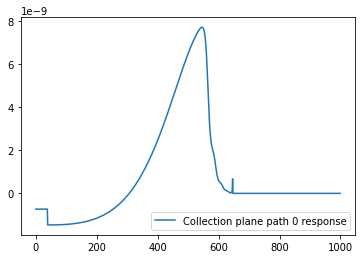

In [3]:
#Plot current in a collection wire from one electron path 
plt.plot(field_response.planes[2].paths[0].current, label='Collection plane path 0 response'); plt.legend()

In [4]:
#Make an electronics response instance, defined by gain and shaping time
elec_response_for_field = ElecResponse.ElecResponse(14., 2.)

In [5]:
#Make an electronics response in the same coarseness
#of the field response.
#Unit of period is ns, shaping time is us
current = field_response.planes[2].paths[0].current
the_response = elec_response_for_field(
    torch.Tensor(
        np.linspace(0, 
                    1e-3*field_response.period*len(current),
                    len(current)
                   )
    )
)

In [6]:
scale_factor = ((1 << 12) - 1) / 1.4e3 #ADC / mV 

In [7]:
scale_factor

2.925

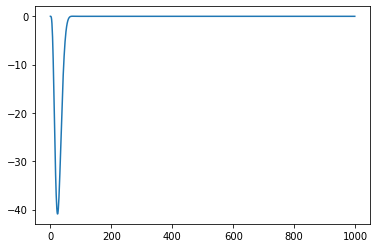

In [8]:
plt.plot((the_response * -1* scale_factor))

In [9]:
#Plot the scaled electronics response in freq domain

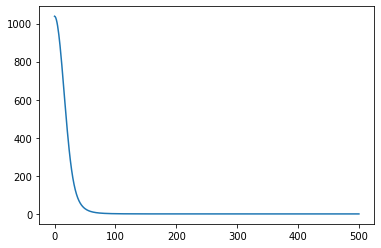

In [10]:
fftd_elec_response = torch.fft.rfft(the_response * -1* scale_factor)
plt.plot(torch.sqrt(fftd_elec_response.real**2 + fftd_elec_response.imag**2))

In [11]:
#Average over the paths for each wire region
avg_response = responses.wire_region_average_allplanes(field_response)

21
0 -10 -47.1
1 -9 -42.39
2 -8 -37.68
3 -7 -32.97
4 -6 -28.259999999999998
5 -5 -23.55
6 -4 -18.84
7 -3 -14.129999999999999
8 -2 -9.42
9 -1 -4.71
10 0 0.0
11 1 4.71
12 2 9.42
13 3 14.129999999999999
14 4 18.84
15 5 23.55
16 6 28.259999999999998
17 7 32.97
18 8 37.68
19 9 42.39
20 10 47.1
21
0 -10 -47.1
1 -9 -42.39
2 -8 -37.68
3 -7 -32.97
4 -6 -28.259999999999998
5 -5 -23.55
6 -4 -18.84
7 -3 -14.129999999999999
8 -2 -9.42
9 -1 -4.71
10 0 0.0
11 1 4.71
12 2 9.42
13 3 14.129999999999999
14 4 18.84
15 5 23.55
16 6 28.259999999999998
17 7 32.97
18 8 37.68
19 9 42.39
20 10 47.1
21
0 -10 -47.1
1 -9 -42.39
2 -8 -37.68
3 -7 -32.97
4 -6 -28.259999999999998
5 -5 -23.55
6 -4 -18.84
7 -3 -14.129999999999999
8 -2 -9.42
9 -1 -4.71
10 0 0.0
11 1 4.71
12 2 9.42
13 3 14.129999999999999
14 4 18.84
15 5 23.55
16 6 28.259999999999998
17 7 32.97
18 8 37.68
19 9 42.39
20 10 47.1


In [12]:
avg_response_tensor = avg_response.as_tensor()

In [13]:
plane2_avg_response = avg_response_tensor[2]

In [14]:
#FFT the plane 2 response
fftd_plane2_avg_response = torch.fft.rfft(plane2_avg_response, axis=1)

In [15]:
#Combine electronics and field responses then do inverse FFT
field_and_elec = torch.fft.irfft(
    (fftd_plane2_avg_response*
     fftd_elec_response*
     avg_response.period*1.e-3), axis=1
)

In [16]:
#Show the electronics x field response in 'log10 scale'
modded = torch.zeros_like(field_and_elec)
good_vals = field_and_elec[torch.where(torch.abs(field_and_elec) > 1e-5)]
modded[torch.where(torch.abs(field_and_elec) > 1e-5)] = torch.sign(good_vals)*torch.log10(1e5*torch.abs(good_vals))

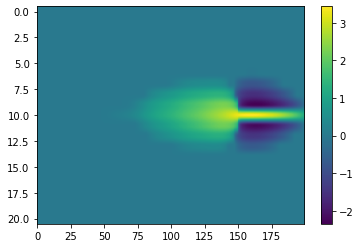

In [17]:
plt.imshow(modded[:,500:700], aspect='auto'); plt.colorbar()

In [18]:
#This is just for demonstration over the entire set of paths 
plane2_response = field_response.as_tensor()[2]
fftd_plane2_response = torch.fft.rfft(plane2_response, axis=1)

In [19]:
# Combining field and electronics response
field_and_elec_full = torch.fft.irfft(
    fftd_plane2_response*fftd_elec_response*1.e-3*field_response.period,
    axis=1
)

In [20]:
#log 10 scale
modded = torch.zeros_like(field_and_elec_full)
good_vals = field_and_elec_full[torch.where(torch.abs(field_and_elec_full) > 1e-5)]
modded[torch.where(torch.abs(field_and_elec_full) > 1e-5)] = torch.sign(good_vals)*torch.log10(1e5*torch.abs(good_vals))

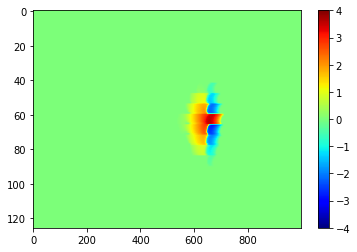

In [21]:
plt.imshow(modded, aspect='auto', vmin=-4, vmax=4, cmap='jet'); plt.colorbar()

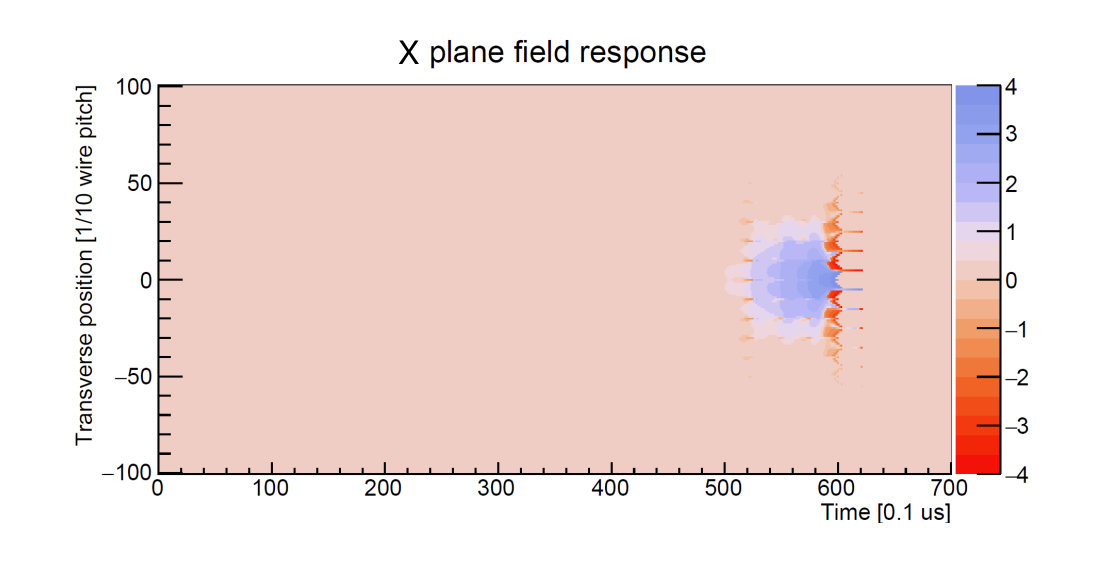

In [22]:
#From PDSP performance paper
from IPython.display import Image
Image("/home/jake/Documents/collection.png")

In [23]:
#Load rawdigits from PDSP simulation
f = h5.File('pdsp_wires.h5')
wires = torch.Tensor(f['wires'][0])

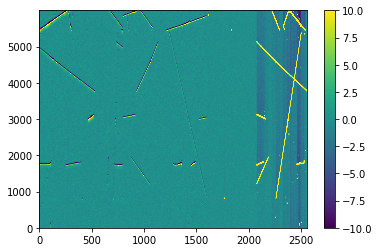

In [24]:
plt.imshow((wires.T - torch.mean(wires, axis=1)), aspect='auto', vmin=-10, vmax=10, origin='lower'); plt.colorbar()

In [25]:
#Getting the collection plane wires and removing pedestal
coll = torch.Tensor(wires[-480:].T - torch.mean(wires[-480:], axis=1)).T

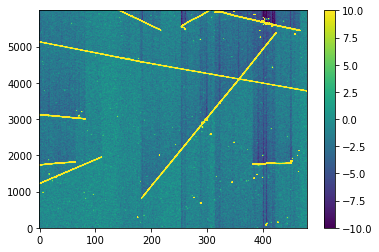

In [26]:
plt.imshow(coll.T, aspect='auto', vmin=-10, vmax=10, origin='lower'); plt.colorbar()

In [27]:
#Redigitize field x electronics response into the same 
redigit = responses.redigitize(field_and_elec, 100*1e-3, .5, 6000)

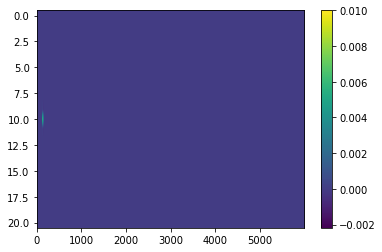

In [28]:
plt.imshow(redigit, aspect='auto', vmax=.01); plt.colorbar()

In [29]:
#FFT redigitized response in both domains
redigit_fftd = torch.fft.fft(torch.fft.rfft(redigit,axis=1), axis=0)

In [30]:
#FFT raw digits in both domains
coll_fftd = torch.fft.fft(torch.fft.rfft(coll,axis=1), axis=0)

In [31]:
#Padd out the redigitized response to match wire width
#then FFT in both domains
padded = torch.zeros_like(coll)
padded[:21] = redigit
padded_fft = torch.fft.fft(torch.fft.rfft(padded, axis=1), axis=0)

In [32]:
#Apply response to fftd raw digits
responsed = coll_fftd/padded_fft

In [33]:
#Make a filter for wire dimension
filter_vals = np.zeros(480)
filter_vals[:240] = np.linspace(0, 1, 240)
filter_vals[240:] = np.linspace(0, 1, 240)[::-1]
filter_vals = np.exp(-.5*(filter_vals/np.sqrt(np.pi))**2)
filter_vals[0] = 0

In [34]:
wire_wf = responsed.T[3000,:]

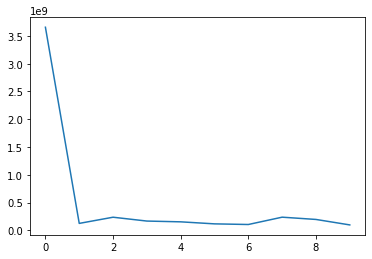

In [35]:
plt.plot(torch.sqrt(wire_wf.real**2 + wire_wf.imag**2)[:10])

/home/jake/.local/lib/python3.8/site-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


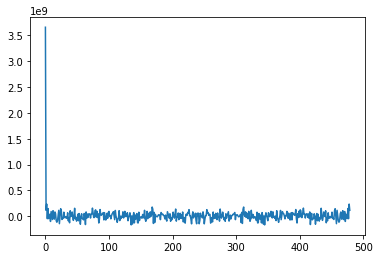

In [36]:
plt.plot(responsed.T[3000,:])

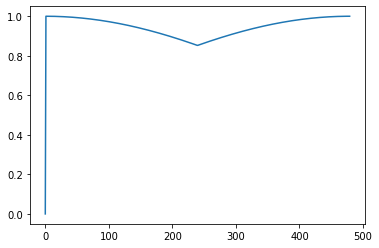

In [37]:
plt.plot(filter_vals)

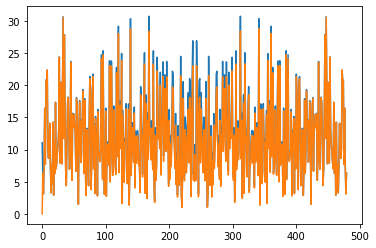

In [38]:

plt.plot(torch.abs(responsed.T[0]))
plt.plot(torch.abs(responsed.T[0])*filter_vals)

In [39]:
#Apply filter, then do inverse FFTs in both directions 
output = torch.fft.irfft(
    torch.fft.ifft(
        (responsed.T*filter_vals).T,
        axis=0
    ),
    axis=1
)

In [40]:
time_offset = 129
wire_offset = 10

In [41]:
output2 = torch.zeros_like(output)
output2[:,:time_offset] = output[:,-time_offset:]
output2[:,time_offset:] = output[:,:-time_offset]

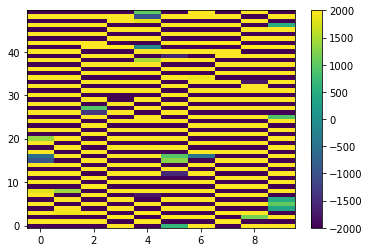

In [42]:
plt.imshow(output2[240:250, 4400:4450].T, aspect='auto', vmin=-2000, vmax=2000, origin='lower'); plt.colorbar()

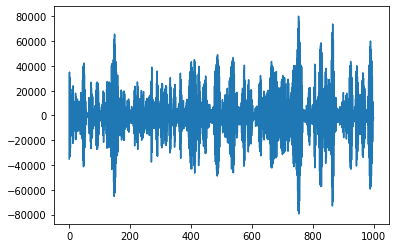

In [43]:
plt.plot(output2[300, 4000:5000])

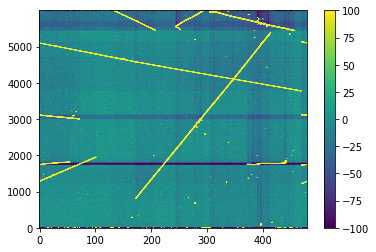

In [44]:
plt.imshow(output2[:,:].T, aspect='auto', vmin=-100, vmax=100, origin='lower');plt.colorbar()

In [45]:
field_response.planes[2].paths[0].pitchpos

-49.455

In [46]:
field_response.planes[2].pitch

4.71

In [47]:
sorted_paths = sorted(field_response.planes[2].paths, key = lambda x : x.pitchpos)

In [48]:
for i in sorted_paths: print(i.pitchpos)

-49.455
-48.984
-48.513
-48.042
-47.571
-47.1
-44.745
-44.274
-43.803
-43.332
-42.861
-42.39
-40.035
-39.564
-39.092999999999996
-38.622
-38.150999999999996
-37.68
-35.324999999999996
-34.854
-34.382999999999996
-33.912
-33.440999999999995
-32.97
-30.615
-30.144
-29.673
-29.201999999999998
-28.730999999999998
-28.259999999999998
-25.905
-25.434
-24.963
-24.492
-24.021
-23.55
-21.195
-20.724
-20.253
-19.782
-19.311
-18.84
-16.485
-16.014
-15.543
-15.072
-14.600999999999999
-14.129999999999999
-11.775
-11.304
-10.833
-10.362
-9.891
-9.42
-7.0649999999999995
-6.593999999999999
-6.123
-5.652
-5.181
-4.71
-2.355
-1.884
-1.413
-0.942
-0.471
0.0
2.355
2.826
3.2969999999999997
3.768
4.239
4.71
7.0649999999999995
7.536
8.007
8.478
8.949
9.42
11.774999999999999
12.245999999999999
12.716999999999999
13.187999999999999
13.658999999999999
14.129999999999999
16.485
16.956
17.427
17.898
18.369
18.84
21.195
21.666
22.137
22.608
23.079
23.55
25.904999999999998
26.375999999999998
26.846999999999998
27.3

In [49]:
len(sorted_paths)/21

6.0

In [50]:
navg = 10 #Number of positions averaged over
npos = int(navg/2 + 1)
print(npos)
[i.pitchpos for i in sorted_paths[:npos]]

6


[-49.455, -48.984, -48.513, -48.042, -47.571, -47.1]

In [51]:
current = np.zeros_like(sorted_paths[0].current)

In [52]:
current += np.array(sorted_paths[0].current) + np.array(sorted_paths[6].current)

In [53]:
new_average = responses.wire_region_average_plane(field_response, plane=2)

21
0 -10 -47.1
1 -9 -42.39
2 -8 -37.68
3 -7 -32.97
4 -6 -28.259999999999998
5 -5 -23.55
6 -4 -18.84
7 -3 -14.129999999999999
8 -2 -9.42
9 -1 -4.71
10 0 0.0
11 1 4.71
12 2 9.42
13 3 14.129999999999999
14 4 18.84
15 5 23.55
16 6 28.259999999999998
17 7 32.97
18 8 37.68
19 9 42.39
20 10 47.1


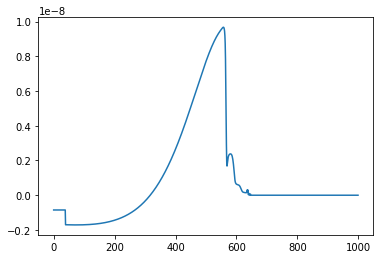

In [54]:
plt.plot(new_average.paths[0].current)

In [55]:
new_fr = responses.wire_region_average_allplanes(field_response, navg=10)

21
0 -10 -47.1
1 -9 -42.39
2 -8 -37.68
3 -7 -32.97
4 -6 -28.259999999999998
5 -5 -23.55
6 -4 -18.84
7 -3 -14.129999999999999
8 -2 -9.42
9 -1 -4.71
10 0 0.0
11 1 4.71
12 2 9.42
13 3 14.129999999999999
14 4 18.84
15 5 23.55
16 6 28.259999999999998
17 7 32.97
18 8 37.68
19 9 42.39
20 10 47.1
21
0 -10 -47.1
1 -9 -42.39
2 -8 -37.68
3 -7 -32.97
4 -6 -28.259999999999998
5 -5 -23.55
6 -4 -18.84
7 -3 -14.129999999999999
8 -2 -9.42
9 -1 -4.71
10 0 0.0
11 1 4.71
12 2 9.42
13 3 14.129999999999999
14 4 18.84
15 5 23.55
16 6 28.259999999999998
17 7 32.97
18 8 37.68
19 9 42.39
20 10 47.1
21
0 -10 -47.1
1 -9 -42.39
2 -8 -37.68
3 -7 -32.97
4 -6 -28.259999999999998
5 -5 -23.55
6 -4 -18.84
7 -3 -14.129999999999999
8 -2 -9.42
9 -1 -4.71
10 0 0.0
11 1 4.71
12 2 9.42
13 3 14.129999999999999
14 4 18.84
15 5 23.55
16 6 28.259999999999998
17 7 32.97
18 8 37.68
19 9 42.39
20 10 47.1


In [56]:
new_tensor = new_fr.as_tensor()
new_fft = torch.fft.rfft(new_tensor[2], axis=1)
#Combine electronics and field responses then do inverse FFT
new_avg_field_elec = torch.fft.irfft(
    (new_fft*
     fftd_elec_response*
     field_response.period*1.e-3), axis=1
)

In [57]:
#log 10 scale
new_modded = torch.zeros_like(new_avg_field_elec)
good_vals = new_avg_field_elec[torch.where(torch.abs(new_avg_field_elec) > 1e-5)]
new_modded[torch.where(torch.abs(new_avg_field_elec) > 1e-5)] = torch.sign(good_vals)*torch.log10(1e5*torch.abs(good_vals))

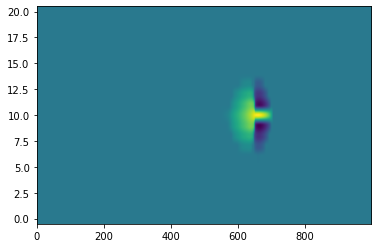

In [58]:
plt.imshow(new_modded, aspect='auto', origin='lower')

In [59]:
all_paths = dict()

In [60]:
for path in sorted_paths:
    all_paths[path.pitchpos] = torch.zeros_like(path.current)
    all_paths[-path.pitchpos] = torch.zeros_like(path.current)

In [61]:
for path in sorted_paths:
    all_paths[path.pitchpos] += path.current
    if path.pitchpos != 0.0: all_paths[-path.pitchpos] += path.current

In [62]:
all_currents = torch.zeros(len(all_paths), len(path.current))

In [63]:
for i, (pos, current) in enumerate(sorted(all_paths.items())):
    all_currents[i] = current

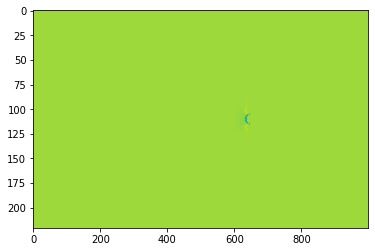

In [64]:
plt.imshow(all_currents, aspect='auto')

In [65]:
#log 10 scale
new_modded2 = torch.zeros_like(all_currents)
good_vals2 = all_currents[torch.where(torch.abs(all_currents) > 1e-5)]
new_modded2[torch.where(torch.abs(all_currents) > 1e-5)] = torch.sign(good_vals2)*torch.log10(1e5*torch.abs(good_vals2))

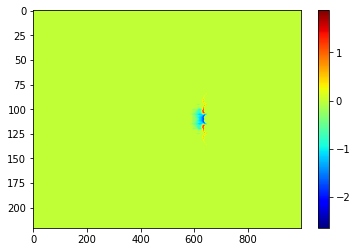

In [66]:
plt.imshow(new_modded2, aspect='auto', cmap='jet'); plt.colorbar()

In [67]:
all_currents_fft = torch.fft.rfft(all_currents, axis=1)
#Combine electronics and field responses then do inverse FFT
new_field_and_elec = torch.fft.irfft(
    (all_currents_fft*
     fftd_elec_response*
     field_response.period*1.e-3), axis=1
)

In [68]:
#log 10 scale
new_modded2 = torch.zeros_like(new_field_and_elec)
good_vals2 = new_field_and_elec[torch.where(torch.abs(new_field_and_elec) > 1e-5)]
new_modded2[torch.where(torch.abs(new_field_and_elec) > 1e-5)] = torch.sign(good_vals2)*torch.log10(1e5*torch.abs(good_vals2))

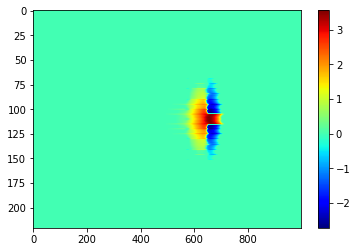

In [69]:
plt.imshow(new_modded2, aspect='auto', cmap='jet'); plt.colorbar()